# Using our facial recognition tool

We trained a couple facial recognition models, let's put them to work!

First: we need to be able to **get faces out of pictures**. We're going to be using [MTCNN](https://github.com/ipazc/mtcnn), which is a neural network that does absolutely nothing but find faces in pictures! We don't need to train it or do anything like that, it's used just like a normal library.

In [1]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 5.5MB/s 


In [2]:
from mtcnn import MTCNN
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

detector = MTCNN()

def get_faces(filename, image_size):
  image = plt.imread(filename)
  faces_coords = detector.detect_faces(image)

  faces = []
  for coords in faces_coords:
    x1, y1, width, height = coords['box']
    x1 = max(x1, 0)
    y1 = max(y1, 0)
    x2, y2 = x1 + width, y1 + height
    face = image[y1:y2, x1:x2]
    face = Image.fromarray(face).resize(image_size)
    face = np.asarray(face)
    faces.append(face)

  return faces

We can test it out by downloading an image of Mitch McConnell.

In [3]:
# Download an image
!wget --quiet https://i.insider.com/606b293ca7d803001963eb9f?width=700 -O mitch.jpg

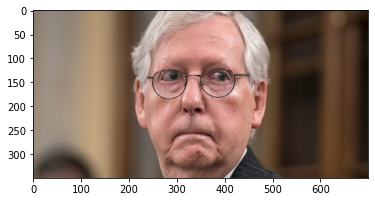

In [4]:
img = plt.imread("mitch.jpg")
plt.imshow(img)

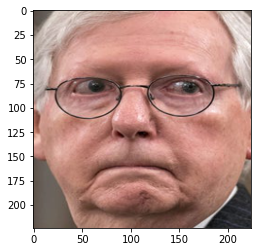

In [18]:
# When we use get_faces, we also need to tell it
# what size images we want back
size = (224, 224)

faces = get_faces("mitch.jpg", size)

# Look at the first face it found
plt.imshow(faces[0])

### Multiple faces

It will also work if there are multiple faces! We'll download Mitch and Nancy Pelosi being grumpy.

In [6]:
!wget --quiet "https://static.politico.com/00/fc/273866e64d898ca21c029af9d2f2/200715-pelosi-mcconnell-ap-773.jpg" -O grumpy.jpg

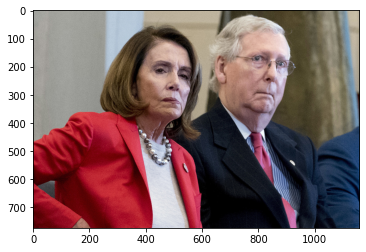

In [7]:
img = plt.imread("grumpy.jpg")
plt.imshow(img)

In [19]:
# Return faces as 100x100 images because we don't
# want them to take up the whole screen or anything!
size = (224, 224)

faces = get_faces("grumpy.jpg", size)
len(faces)

2

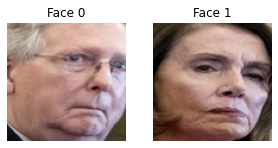

In [9]:
# Loop through each face, display it
plt.figure(figsize=(10, 10))
for i, face in enumerate(faces):
  label = f"Face {i}"
  ax = plt.subplot(4, 4, i + 1)

  plt.imshow(face)
  plt.title(f"Face {i}")
  plt.axis("off")

## Doing facial recognition

To do facial recognition, we need to bring in the models we trained. They live on our Google Drive, so let's connect that now.

In [10]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [11]:
!ls /content/gdrive/MyDrive/models

congress_labels.json  face_recognition_v1  face_recognition_v2


Now we'll import our first model right from Google Drive!

In [16]:
import tensorflow as tf
from tensorflow import keras

model = keras.models.load_model('/content/gdrive/MyDrive/models/face_recognition_v1')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 536)               686616    
Total params: 2,944,600
Trainable params: 2,910,488
Non-trainable params: 34,112
_________________________________________________________________


This is the code we used in class to make a prediction. It worked then, but now it gives us an error, because something is wrong with our face images that makes it incompatible with our model. **You'll need to change something up above, then re-run this code.**

In [20]:
# Make a prediction!!!
img = faces[0]

img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Divide by 255 to make RGB values 0-1 instead of 0-255
scores = model.predict(img_array / 255)[0]
scores

array([0.00222509, 0.00078528, 0.00163921, 0.00043632, 0.00198899,
       0.00059509, 0.00287984, 0.00095737, 0.0011287 , 0.00100973,
       0.0051665 , 0.00110548, 0.00168439, 0.00109432, 0.00120109,
       0.00454176, 0.00118022, 0.00285491, 0.00157824, 0.00049445,
       0.00201184, 0.00139451, 0.00175667, 0.00103479, 0.0039093 ,
       0.00314594, 0.00083127, 0.00158719, 0.00206774, 0.00071934,
       0.00711743, 0.00433707, 0.00253748, 0.00361378, 0.00122842,
       0.00192225, 0.00110663, 0.00174664, 0.00143153, 0.00085462,
       0.00109533, 0.00030913, 0.00152314, 0.00241363, 0.00137283,
       0.00192687, 0.00033448, 0.0006722 , 0.00102209, 0.00136283,
       0.00474878, 0.00232529, 0.00035203, 0.00273339, 0.00263584,
       0.00221971, 0.00132653, 0.00329194, 0.00090781, 0.00177468,
       0.00157348, 0.00047265, 0.0009363 , 0.00123122, 0.0013051 ,
       0.00108061, 0.00211227, 0.00147787, 0.00086734, 0.00139545,
       0.00239174, 0.00048466, 0.00148372, 0.00045124, 0.00153

Once it's finally working, it gives you a lot of awful numbers. **Each number is one probability score for each member of Congress**. We can ask for the index of the largest, just like we did with gibbons and goldfish and all of that.

In [21]:
np.argmax(scores)

134

Okay, it's that's the number of the person it is. We saved the class labels separately, let's read them in now.

In [23]:
import json

with open('/content/gdrive/MyDrive/models/congress_labels.json', 'r') as fp:
  class_names = json.load(fp)

class_names[134]

'deb_fischer'

**Who is it predicting as the owner of the face?** Is that correct?

In [24]:
# Deb Fisher, not correct

**How certain is our model that this is the right answer?**

*Hint: what variable has the probabilities?*

In [25]:
scores[134]

0.0151024405

If it isn't very sure or it isn't very correct, we can take a look at the second or third most likely label. Let's steal some code from class and look at the **top 5 likeliest labels**.

In [26]:
predictions = np.argsort(scores)[::-1]
for pred in predictions[:5]:
  score = scores[pred]
  label = class_names[pred]
  print(f"{label}: {score:.2%}")

deb_fischer: 1.51%
pete_aguilar: 1.07%
gary_palmer: 0.96%
mark_green: 0.90%
suzan_delbene: 0.87%


How do we feel about it? Did it do a good job?

In [ ]:
# No, it's supposed to be Mitch McConnell and mine predicted a woman

Now let's find the likeliest predictions for the second face in the image.

**Start by copying the "Make a prediction!!!" code, and finish by listing the top 5 most likely labels.** Make sure it's doing a prediction for the second face in the image this time – your results should be different.

In [29]:
# Get your prediction scores
img = faces[1]

img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Divide by 255 to make RGB values 0-1 instead of 0-255
scores = model.predict(img_array / 255)[0]
score

0.00871713

In [30]:
# Top 5 labels
predictions = np.argsort(scores)[::-1]
for pred in predictions[:5]:
  score = scores[pred]
  label = class_names[pred]
  print(f"{label}: {score:.2%}")

bill_huizenga: 1.42%
elaine_luria: 1.14%
jim_banks: 1.06%
deb_fischer: 1.05%
emanuel_cleaver: 0.96%


### Let's do this all at once

Because we love convenience, let's display the image, get the predictions, loop through, display it all.

Run the code below. It should work fine.

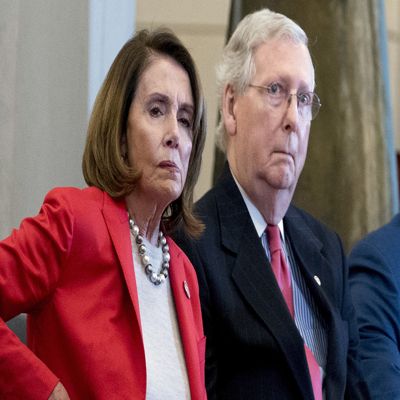

---------


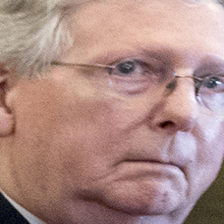

* deb_fischer: 1.51%
* pete_aguilar: 1.07%
* gary_palmer: 0.96%
* mark_green: 0.90%
* suzan_delbene: 0.87%
---------


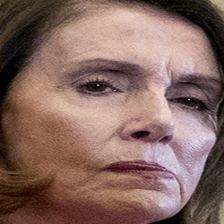

* bill_huizenga: 1.42%
* elaine_luria: 1.14%
* jim_banks: 1.06%
* deb_fischer: 1.05%
* emanuel_cleaver: 0.96%


In [31]:
from IPython.display import display

# Filename of the image to look at
filename = "grumpy.jpg"

# Size of the images
size = (224, 224)

# Print the image
display(Image.open(filename).resize((400,400)))

# Grab the faces
faces = get_faces(filename, size)

# Make predictions for all faces at once
# Divide by 255 to make RGB values 0-1 instead of 0-255
predictions = model.predict(np.array(faces) / 255)

# Loop through each face and the predictions
for face, scores in zip(faces, predictions):
  print("---------")
  # Display the face
  display(Image.fromarray(face))

  # Show the top 5 scores
  predictions = np.argsort(scores)[::-1]
  for pred in predictions[:5]:
    score = scores[pred]
    label = class_names[pred]
    print(f"* {label}: {score:.2%}")


Cool, yeah?

# Trying our other model

Our first model and our second model performed very differently during training, so let's try the second model now.

**Re-use the `load_model` code from up above. Make a small edit to load v2 of our face recognition software.**

In [32]:
# Load v2 of the model
import tensorflow as tf
from tensorflow import keras

model = keras.models.load_model('/content/gdrive/MyDrive/models/face_recognition_v2')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 128)               22808144  
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 536)               69144     
Total params: 45,656,600
Trainable params: 22,848,456
Non-trainable params: 22,808,144
_________________________________________________________________


We'll put the downloading stuff down here, too, in case you want to try a different image.

In [33]:
# Download the image
!wget --quiet "https://static.politico.com/00/fc/273866e64d898ca21c029af9d2f2/200715-pelosi-mcconnell-ap-773.jpg" -O grumpy.jpg

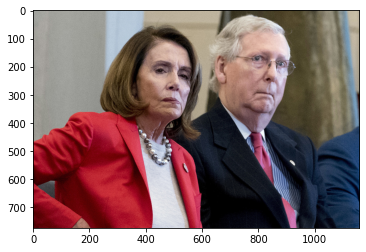

In [34]:
# Preview the image
img = plt.imread("grumpy.jpg")
plt.imshow(img)

In the cell below, copy and paste "Let's do this all at once" code to make predictions for all of the faces in the image.

**You'll get an error**. Even though v1 and v2 might both be ResNet50, there are a couple differences. One is that v1 is trained on ImageNet and v2 is trained on FaceNet, but there's ooooone more difference which will make you change one line of code...

**Edit the "Let's do this all at once" code below to successfully make predictions.**

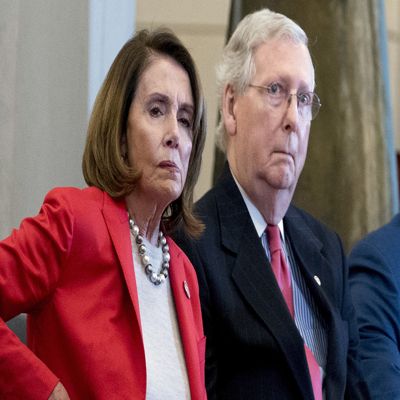

---------


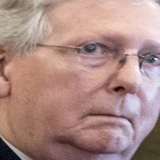

* mitch_mcconnell: 97.44%
* patty_murray: 0.61%
* jerry_carl: 0.53%
* bernard_sanders: 0.21%
* harold_rogers: 0.16%
---------


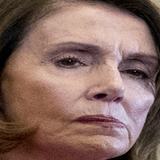

* nancy_pelosi: 53.98%
* debbie_stabenow: 14.18%
* debbie_dingell: 10.36%
* elizabeth_warren: 9.13%
* ann_kirkpatrick: 2.12%


In [35]:
from IPython.display import display

# Filename of the image to look at
filename = "grumpy.jpg"

# Size of the images
size = (160, 160)

# Print the image
display(Image.open(filename).resize((400,400)))

# Grab the faces
faces = get_faces(filename, size)

# Make predictions for all faces at once
# Divide by 255 to make RGB values 0-1 instead of 0-255
predictions = model.predict(np.array(faces) / 255)

# Loop through each face and the predictions
for face, scores in zip(faces, predictions):
  print("---------")
  # Display the face
  display(Image.fromarray(face))

  # Show the top 5 scores
  predictions = np.argsort(scores)[::-1]
  for pred in predictions[:5]:
    score = scores[pred]
    label = class_names[pred]
    print(f"* {label}: {score:.2%}")


Did it do any better?

In [36]:
# Yes! Much better!!